<a href="https://colab.research.google.com/github/Frank1497/Emotion-Classifier/blob/main/Emotion_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Uploading Data**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!ls '/content/drive/MyDrive/data/EM2.rar'

/content/drive/MyDrive/data/EM2.rar


In [3]:
!unrar x -Y "/content/drive/MyDrive/data/EM2.rar"


Streaming output truncated to the last 5000 lines.
Extracting  EM2/train/sad/im3700.png                                      85%  OK 
Extracting  EM2/train/sad/im3701.png                                      85%  OK 
Extracting  EM2/train/sad/im3702.png                                      85%  OK 
Extracting  EM2/train/sad/im3703.png                                      85%  OK 
Extracting  EM2/train/sad/im3704.png                                      85%  OK 
Extracting  EM2/train/sad/im3705.png                                      86%  OK 
Extracting  EM2/train/sad/im3706.png                                      86%  OK 
Extracting  EM2/train/sad/im3707.png                                      86%  OK 
Extracting  EM2/train/sad/im3708.png                                      86%  OK 
Extracting  EM2/train/sad/im3709.png                                      86%  OK 
Extracting  EM2/train/sad/im3

In [4]:
import os
os.listdir('/content/EM2')

['train', 'test']

**Preprocessing Data**

In [14]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img_size = 48
batchsize = 64
lr =0.0001


Preprocessing Training Data

In [15]:
from keras.preprocessing.image import ImageDataGenerator

train_dir = '/content/EM2/train'
train_datagen = ImageDataGenerator(rescale=1./255,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                  #  zoom_range=0.2,
                                  #  shear_range=0.1,
                                  #  rotation_range=10,
                                   horizontal_flip=True
                                   )

#Creating Batch Size
train_generator = train_datagen.flow_from_directory(train_dir , batch_size=batchsize, target_size=(img_size, img_size))

Found 28708 images belonging to 7 classes.


Preprocessing Validation Data

In [16]:
validation_dir = '/content/EM2/test'

validation_datatgen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datatgen.flow_from_directory(validation_dir , batch_size=batchsize, target_size=(img_size, img_size))

Found 7178 images belonging to 7 classes.


In [17]:
label_map = train_generator.class_indices
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
label_map
num_classes = len(label_map)

**Building Model**

In [18]:
from keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.applications.vgg16 import VGG16, preprocess_input

In [19]:
model = Sequential()
model.add(Conv2D(64, (3, 3), input_shape=(img_size, img_size, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.2))

model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 48, 48, 64)        1792      
                                                                 
 batch_normalization_6 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_7 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                      

In [20]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("emotion_checkpointmodel.h5",
                             monitor='val_loss',
                             mode='min',
                             verbose=0,
                             save_best_only=True,
                             )

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001,
                              )

callbacks = [checkpoint, earlystop, reduce_lr]

model.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics='accuracy')

train_samples = 28708  
validation_samples = 7178 

history = model.fit(train_generator, 
                    steps_per_epoch=train_generator.n // train_generator.batch_size, 
                    validation_data=validation_generator, 
                    validation_steps=validation_generator.n // validation_generator.batch_size, 
                    epochs=50,
                    shuffle=1,
                    callbacks=callbacks,
                    verbose=1)
model.save('emotion_model.h5')

Epoch 1/50
448/448 [==============================] - 52s 113ms/step - loss: 1.8683 - accuracy: 0.2516 - val_loss: 1.7529 - val_accuracy: 0.2815 - lr: 1.0000e-04
Epoch 2/50
448/448 [==============================] - 50s 111ms/step - loss: 1.6988 - accuracy: 0.3272 - val_loss: 1.4938 - val_accuracy: 0.4269 - lr: 1.0000e-04
Epoch 3/50
448/448 [==============================] - 50s 111ms/step - loss: 1.5778 - accuracy: 0.3816 - val_loss: 1.4144 - val_accuracy: 0.4593 - lr: 1.0000e-04
Epoch 4/50
448/448 [==============================] - 50s 110ms/step - loss: 1.4840 - accuracy: 0.4225 - val_loss: 1.6331 - val_accuracy: 0.4314 - lr: 1.0000e-04
Epoch 5/50
448/448 [==============================] - 50s 111ms/step - loss: 1.4074 - accuracy: 0.4632 - val_loss: 1.2704 - val_accuracy: 0.5165 - lr: 1.0000e-04
Epoch 6/50
448/448 [==============================] - 50s 111ms/step - loss: 1.3483 - accuracy: 0.4828 - val_loss: 1.2543 - val_accuracy: 0.5216 - lr: 1.0000e-04
Epoch 7/50
448/448 [========

Text(0.5, 0, 'epoch')

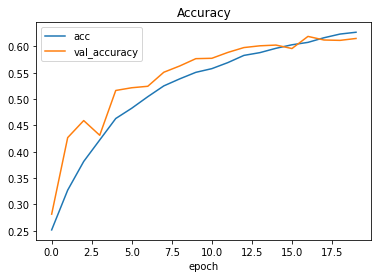

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['acc', 'val_accuracy'])
plt.title('Accuracy')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

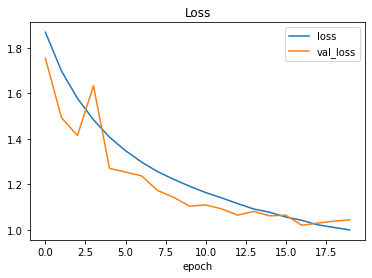

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('Loss')
plt.xlabel('epoch')